# 선형 분류 모델

## 이항분류 모델 --> 맞거나 틀리거나 --> 최적의 결정경계선 찾기

In [8]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from ch09 import *
from helper import generate_batches
plt.rcParams['figure.figsize'] = (4, 4)

In [10]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)
print(xy)
print(labels)

[[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]]


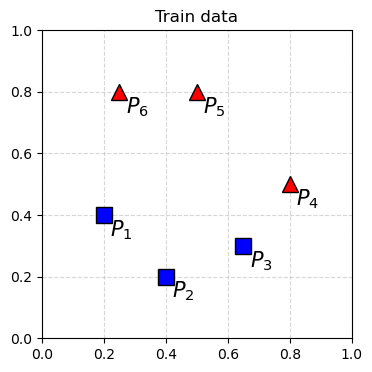

In [13]:
example_plot_wo_contour(xy, labels, 'Train data')

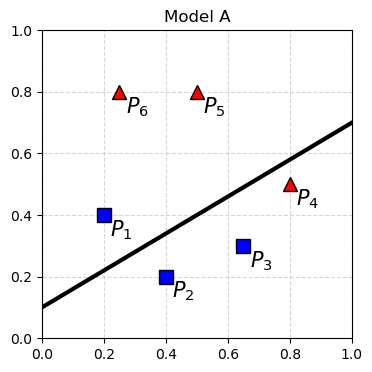

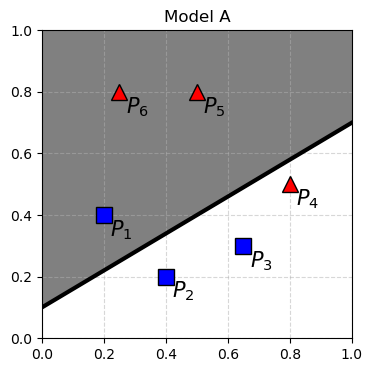

In [19]:
example_plot_only_line(xy, labels, 0.6, .1, 'Model A') #기울기 0.6, y절편 0.1
example_plot(xy, labels, 0.6, .1, 'Model A')

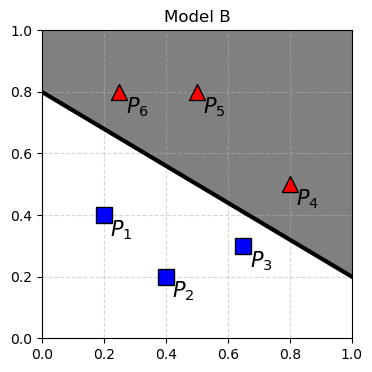

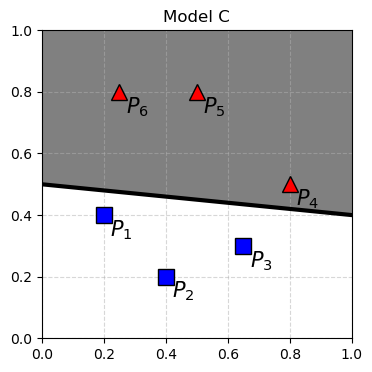

In [17]:
example_plot(xy, labels, -.6, .8, 'Model B')
example_plot(xy, labels, -.1, .5, 'Model C')

### 틀린 개수를 가장 적게 하는 결정경계선을 찾는 최적화 문제 --> $min_{a,b}E(a,b)$

### 손실함수를 오답 개수로 설정하여 텐서플로우를 사용하면 안되나? --> 오답의 개수가 같을때 더 좋은 모델 구분 불가

### 이분법적 예측 대신 확률 모델 적용하면 평가 가능

## 시그모이드 함수

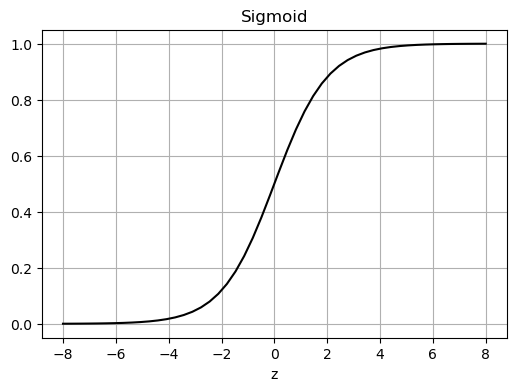

In [25]:
tmp = np.linspace(-8,8)
sigmoid = lambda z:  1.0 / (1+np.exp(-z))

plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(tmp, sigmoid(tmp), 'k')
plt.grid()
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

In [27]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 결정경계선의 일반형 식의 계수(W)
        self.b = tf.Variable([-8.]) # 결정경계선의 일반형 식의 상수항(b)

    def call(self, x): # x: 데이터 좌표 (x,y)
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

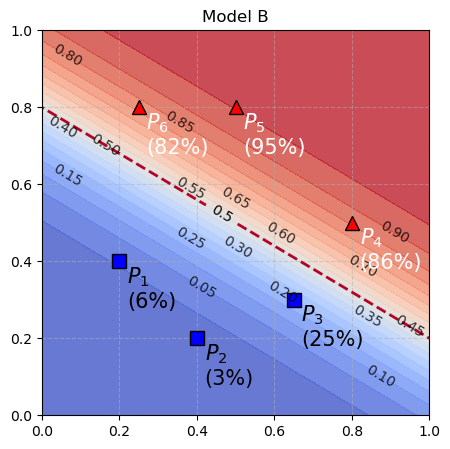

In [29]:
feature = lambda x, y: [x,y]
plot_model(model, feature, xy, labels, 'Model B')

In [31]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[10.]])
        self.b = tf.Variable([-5.])

    def call(self, x):
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

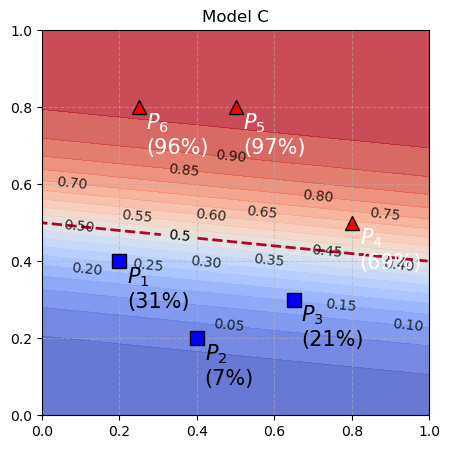

In [33]:
feature = lambda x, y: [x,y]
plot_model(model, feature, xy, labels, 'Model C')

### 확률이 0.5인곳 --> 결정경계선

## 최대 우도법 --> 학습용 정답 데이터를 정답이라고 예측할 확률을 최대화하는 방법 --> 확률 곱하여 비교

In [40]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 결정경계선의 일반형 식의 계수(W)
        self.b = tf.Variable([-8.]) # 결정경계선의 일반형 식의 상수항(b)

    def call(self, x): # x: 데이터 좌표 (x,y)
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

In [42]:
model = MyModel()

pred = model(xy).numpy()
print(pred)
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(prob)

[[0.05732416]
 [0.026597  ]
 [0.24973983]
 [0.85814893]
 [0.95257413]
 [0.8175745 ]]
[[0.9426758 ]
 [0.973403  ]
 [0.7502602 ]
 [0.85814893]
 [0.95257413]
 [0.8175745 ]]
0.46010372


## 크로스 엔트로피 --> 최대우도의 값에 $-log$를 취한 것뿐 --> 확률을 곱하기 떄문에 데이터가 많아지면 값이 많아짐 --> 이를 막아줌

In [45]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)

class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) 
        self.b = tf.Variable([-1.]) 

    def call(self, x): 
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

loss = lambda p, phat: tf.reduce_mean(- p * tf.math.log(phat) - (1 - p) * tf.math.log(1 - phat))

model = MyModel()

In [47]:
features = xy

MaxEpochs = 50
lr = 1.0
optimizer = tf.keras.optimizers.Adam(lr)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    if epoch % 5 == 0:
        curr_loss = loss(labels, model(features))
        print(model.w.numpy().T, model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1. 1.]] [-1.] 0.57861006
[[0.25679404 2.7253065 ]] [-2.2425592] 0.52684075
[[1.2269577 5.803084 ]] [-2.511906] 0.3587352
[[0.78064704 7.2956853 ]] [-4.387419] 0.25905302
[[1.9248078 9.424853 ]] [-5.050756] 0.18241799
[[ 2.561283 10.770934]] [-6.1916285] 0.13992597
[[ 3.0603893 11.742465 ]] [-7.369895] 0.11698827
[[ 4.066818 12.919808]] [-7.965677] 0.09489021
[[ 4.6228566 13.727169 ]] [-8.742903] 0.08052511
[[ 4.965785 14.36889 ]] [-9.51242] 0.071203925


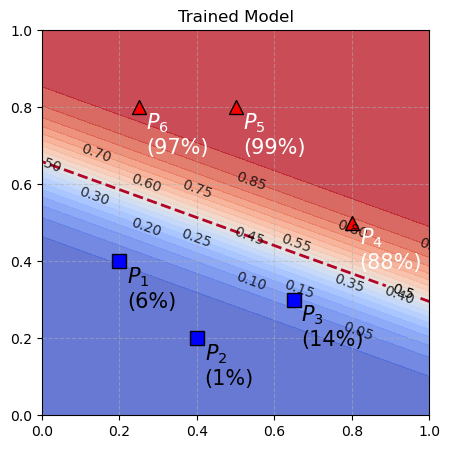

In [49]:
plot_model(model, lambda x, y: [x,y], xy, labels, 'Trained Model')

## 결정경계선이 직선이 아닐때

In [52]:
from sklearn.datasets import make_circles
xy, labels = make_circles(n_samples=400, noise=0.1)

In [56]:
# 특성값 정의
features = np.array([[xval**2, yval**2] for xval, yval in xy])

In [58]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) 
        self.b = tf.Variable([-0.25]) 

    def call(self, x): 
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [60]:
model = MyModel()

loss = lambda p, phat: tf.reduce_mean(- p * tf.math.log(phat) - (1 - p) * tf.math.log(1 - phat))

In [62]:
def plot_model(model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.5,1.5, 200), np.linspace(-1.5,1.5, 200))
    inputs_xy = np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])
    prediction = model(inputs_xy).numpy()
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    colors = {0:'red', 1:'blue'}
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    ax.contourf(xx, yy, Z, 5, cmap='coolwarm', alpha=.9)
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    grouped = df.groupby('label')
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k]], mec='k', alpha=0.6)
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

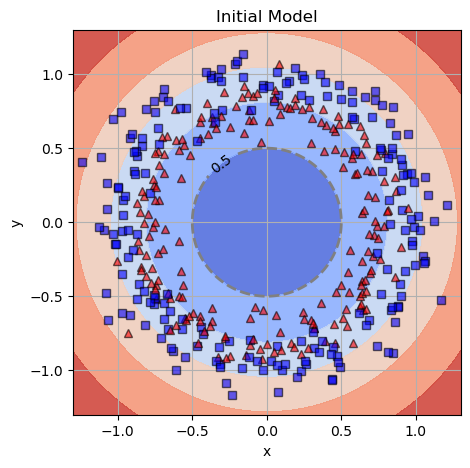

In [64]:
model = MyModel()
plot_model(model, lambda x,y: [x**2, y**2], 'Initial Model')

In [71]:
# 수치최적화 알고리즘
MaxEpochs = 100
lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

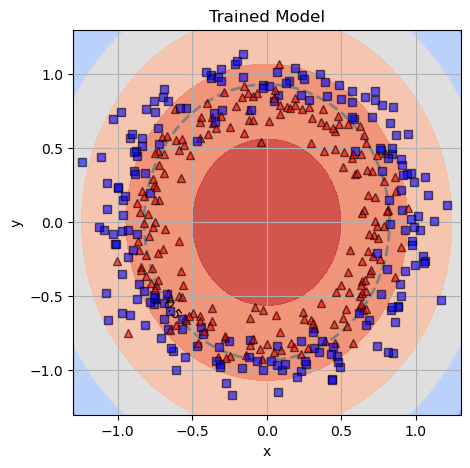

In [68]:
plot_model(model, lambda x,y: [x**2, y**2], 'Trained Model')

# 다중분류

### 이항분류와 가장 큰 차이 --> 이항 예측값 항상 스칼라 but 다중 예측값 벡터

### 원-핫 인코딩 --> 모든 레이블에 1은 한개 나머지는 0

In [77]:
np.random.seed(402)
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])

# 특성값 정의
features = np.array([[xval, yval] for xval, yval in xy])
print('좌표 데이터:\n', features, '\n')

# 원-핫 인코딩
labels = np.array([[0, 1],[0, 1],[0, 1],[1, 0],[1, 0],[1, 0]])
print('레이블:\n', labels)

좌표 데이터:
 [[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]] 

레이블:
 [[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]]


In [80]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.W = tf.Variable(tf.ones([2,2]), dtype=tf.float32) 
        self.b = tf.Variable(tf.ones([2]), dtype=tf.float32) 

    def call(self, x):
        return tf.nn.softmax(tf.matmul(x, self.W) + self.b)

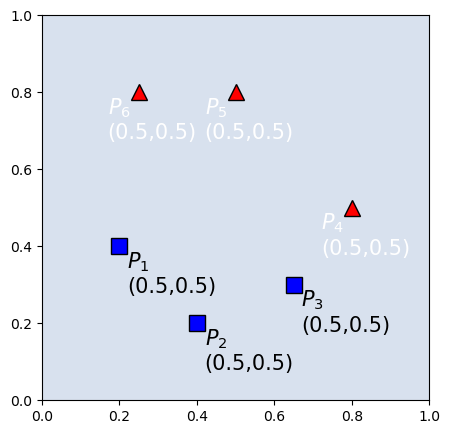

In [82]:
model = MyModel()
plot_scatter_softmax(model.W.numpy(), model.b.numpy(), xy, labels)

In [84]:
loss = lambda p, phat: tf.reduce_mean(tf.reduce_sum(- p * tf.math.log(phat),1))

MaxEpochs = 25
lr = 0.5
optimizer = tf.keras.optimizers.Adam(lr)

In [86]:
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

from helper import generate_batches

batch_size = 3
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 5 == 0:
        print(epoch, model.W.numpy(), model.b.numpy(), curr_loss.numpy())

0 [[1.945563   0.05443704]
 [0.8577205  1.1422795 ]] [0.72328013 1.2767199 ] 1.2344422
5 [[ 1.6084906   0.39150962]
 [ 2.971559   -0.9715587 ]] [-0.19685197  2.1968522 ] 0.3975285
10 [[ 1.616149    0.38385153]
 [ 4.739495   -2.7394943 ]] [-1.219996   3.2199957] 0.1698374
15 [[ 2.324847   -0.32484618]
 [ 6.0415444  -4.041544  ]] [-2.0235872  4.0235868] 0.123032205
20 [[ 2.9550228 -0.9550221]
 [ 6.91511   -4.9151096]] [-2.749179  4.749178] 0.09799708


In [88]:
print(loss(labels,model(features)).numpy())

print('W:\n', model.W.numpy())
print('b:\n', model.b.numpy())
print('prediction:\n', model(features).numpy())

0.087647684
W:
 [[ 3.2890172 -1.2890162]
 [ 7.4371214 -5.4371204]]
b:
 [-3.2588093  5.258808 ]
prediction:
 [[0.0792695  0.9207305 ]
 [0.01611822 0.98388183]
 [0.15714537 0.84285456]
 [0.82947767 0.1705223 ]
 [0.9832224  0.01677756]
 [0.9491306  0.05086941]]


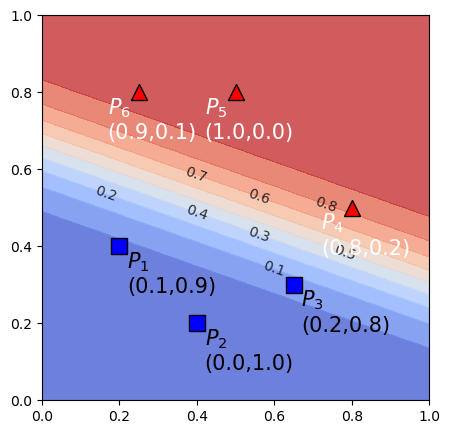

In [90]:
plot_scatter_softmax(model.W.numpy(), model.b.numpy(), xy, labels)